In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Some initial predictions:

Sex will be the single biggest predictor of survival, followed by age   (young uns might not have survived)

Rich-ness may be a negative predictor of survival


Different considerations:
- did they get into a lifeboat                     --> age, sex, affluence
- did they go down with the ship                   --> age, location on ship
- were they able to tread water until being saved  --> age / stamina,

- How balanced are the two classes?

Features that will be useful:
- Age < 18   (Age < 13   Age < 10 , ...?)
- has family  (sibsp, parch columns)
- has children
- is rich --> pclass, higher passenger fare / which cabin / etc   (premium passenger)
    - >> correlate cabin with fare and pclass

- cabin number?  --> certain cabins may have been lower on the ship

Features that may be useful, or at least interesting:
- is married   (Mrs vs Miss,  sibsp column, what to do for men?  --> (sibsp column only?) )

- Age > 60,  Age > 70, etc


Features that may not be useful
- port of embark

In [ ]:
df = pd.read_csv("data/train.csv", index_col=0)
print(df.columns)
df.head(5)

In [26]:
def preprocess(_df: pd.DataFrame) -> pd.DataFrame:
    _df['SexBinary'] = (_df['Sex'] == 'female').astype(int)
    _df = pd.get_dummies(_df, columns=['Sex'], dtype=int, prefix="is")

    ports = {'S': 0, 'C': 1, 'Q': 2, np.nan: 3}
    _df['Embarked'] = _df['Embarked'].map(lambda port: ports.get(port))

    _df['Ticket'] = _df['Ticket'].fillna('0').apply(lambda t: re.sub(r"[^\d]", '', t))
    _df['Ticket'] = _df['Ticket'].replace('', '0')
    _df['Ticket'] = _df['Ticket'].astype(int)

    _df['is_child'] = (_df['Age'] < 18).astype(int)
    _df['is_senior'] = (_df['Age'] >= 60).astype(int)
    _df['has_family'] = ((_df['SibSp'] > 0) | (_df['Parch'] > 0)).astype(int)
    _df['is_rich'] = ((_df['Pclass'] <= 2) & (_df['Fare'] > 31)).astype(int)
    _df['is_poor'] = ((_df['Pclass'] == 3) & (_df['Fare'] < 31)).astype(int)

    return _df

In [16]:
df['SexBinary'] = (df['Sex'] == 'female').astype(int)
df = pd.get_dummies(df, columns=['Sex'], dtype=int, prefix="is")

ports = {'S': 0, 'C': 1, 'Q': 2, np.nan: 3}
df['Embarked'] = df['Embarked'].map(lambda port: ports.get(port))

In [17]:
df['Ticket'] = df['Ticket'].fillna('0').apply(lambda t: re.sub(r"[^\d]", '', t))
df['Ticket'] = df['Ticket'].replace('', '0')
df['Ticket'] = df['Ticket'].astype(int)#.sort_values().head(20)

#### Classes are Imbalanced

In [4]:
# Can balance classes or optimize for various metrics

df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [114]:
print(df.columns)
df.head()

Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'SexBinary', 'is_female', 'is_male'],
      dtype='object')


,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexBinary,is_female,is_male
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,1,0
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,1,1,0
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,0,1


In [213]:
df[['Fare']].describe()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


In [18]:
cmap = mcolors.LinearSegmentedColormap.from_list(
    "MWG",
    [(0.0, "magenta"), (0.5, "white"), (1.0, "green")]
)

norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

def corr_matrix(*args, **kwargs):
    return sns.heatmap(*args, **kwargs,  norm=norm,
                       cmap=cmap,vmin=-1,vmax=1,center=0,cbar=True)

In [19]:
df[df['Pclass'] == 1]['Ticket'].describe()

count       216.000000
mean      49791.268519
std       45009.334714
min         693.000000
25%       17476.750000
50%       17761.000000
75%      111583.500000
max      113807.000000
Name: Ticket, dtype: float64

|## Feature Engineering

In [20]:
df['is_child'] = (df['Age'] < 18).astype(int)
df['is_senior'] = (df['Age'] >= 60).astype(int)
df['has_family'] = ((df['SibSp'] > 0) | (df['Parch'] > 0)).astype(int)
df['is_rich'] = ((df['Pclass'] <= 2) & (df['Fare'] > 31)).astype(int)
df['is_poor'] = ((df['Pclass'] == 3) & (df['Fare'] < 31)).astype(int)

# df['old_and_rich'] = ((df['is_rich'] == 1) & (df['is_senior']))
# df['young_and_poor'] = ((df['is_rich'] == 0) & (df['Age'] >= 18) & (df['Age'] < 60))
# df['poor_man'] = ((df['is_poor']) & (df['is_male']))
# df['rich_woman'] = ((df['is_rich']) & (df['is_female']))

<Axes: >

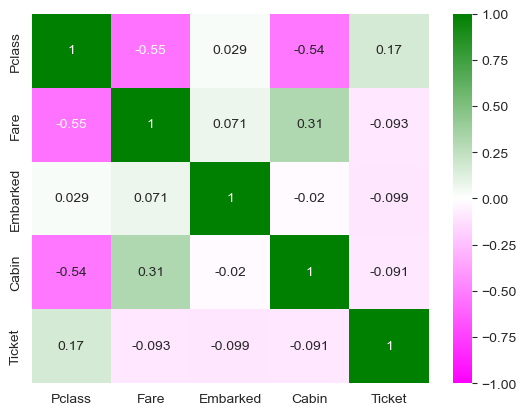

In [236]:
corr_matrix(df[['Pclass', 'Fare', 'Embarked', 'Cabin', 'Ticket']].corr(), annot=True)#with(df['Survived']), annot=True)

In [233]:
df['Cabin'] = df['Cabin'].fillna('').astype('category').cat.codes

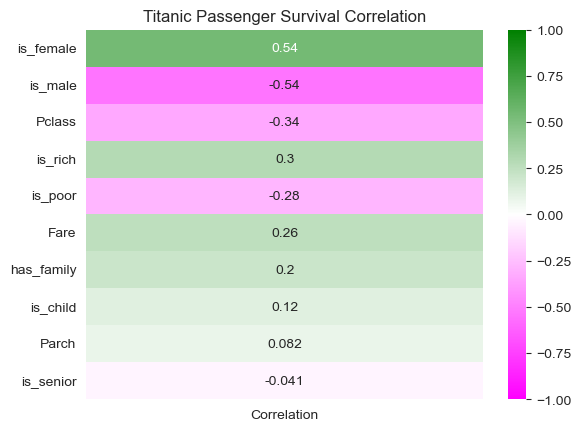

In [21]:
series = df.drop(columns=['Name',  'Survived', 'SibSp', 'Age', 'Ticket', 'Cabin', 'Sex',
                          'Embarked', 'SexBinary',], errors='ignore').corrwith(df['Survived']).to_frame('Correlation')
# sort_by = abs(series['Correlation'])
# series.sort_values(by=sort_by, ascending=False, inplace=True)
corr_matrix(
    series.sort_values(by="Correlation", key=lambda c: abs(c), ascending=False), annot=True, #vmin=-1, vmax=1, cmap="PiYG"

)
plt.title("Titanic Passenger Survival Correlation", fontsize=12)
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X = df.drop(columns=['Name',  'Survived', 'SibSp', 'Age', 'Embarked', 'SexBinary', 'Sex', 'Ticket', 'Cabin',
                     ], errors='ignore')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = XGBClassifier()
# model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [54]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy*100:.2f}%")

Model Accuracy: 82.84%


In [55]:
# 8. (Optional) Make a prediction on a new single row of data
# Ensure the new data has the same column structure as X_train
test_df = pd.read_csv("data/test.csv", index_col=0)
test_df = preprocess(test_df)

predicted = rf_classifier.predict(test_df.drop(columns=['Name', 'Survived', 'SibSp', 'Age', 'Embarked', 'SexBinary', 'Sex', 'Ticket', 'Cabin'], errors='ignore'))
print(f"Prediction for new data: {predicted}")

Prediction for new data: [0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 0 0 0]


In [56]:
len(predicted)

418

In [57]:
with open("data/predictions.csv", "w") as f:
    f.write("PassengerId,Survived\n")
    for _id, pred in zip(test_df.index.values.tolist(), predicted):
        f.write(f"{_id},{pred}\n")


In [1]:
X_train


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

split = int(len(X_train)/11)
print(f"Validation split: {split}/{len(X_train)}")
X_valid, X_train = X_train[:split], X_train[split:]
y_valid, y_train = y_train[:split], y_train[split:]

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
history = model.fit(
    X_train, y_train, epochs=20,
    validation_data = (X_valid, y_valid),
    verbose=0
)

pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test)


In [ ]:
sample_df = df.sample(
    frac=0.7,
    random_state=random_seed
)

# Get the remaining rows by filtering out the indices present in the sample
# The tilde (~) operator negates the boolean selection
remainder_df = df[~df.index.isin(sample_df.index)]